<a href="https://colab.research.google.com/github/Natadsada/audio-video/blob/main/Project_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# In a Colab code cell
!pip install pandas numpy tensorflow tensorflow-text opencv-python scikit-learn matplotlib seaborn

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

# IMPORTANT: Authenticate with Kaggle if you are using Kaggle datasets
# from IPython import get_ipython
# from IPython.display import display
# import kagglehub
# # If using a Kaggle dataset, uncomment and replace with your dataset slug
# # yousefmohamed20_sentiment_images_classifier_path = kagglehub.dataset_download('yousefmohamed20/sentiment-images-classifier')
# # print('Data source import complete.')




In [ ]:
# --- 1. Function to extract frames from a video ---
def extract_frames(video_path, num_frames=30, target_size=(224, 224)):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames <= 0:
        print(f"Warning: Could not read frames from {video_path}")
        return np.array(frames)

    if total_frames < num_frames:
        # If video is shorter than desired frames, take all frames
        indices = range(total_frames)
    else:
        # Otherwise, sample frames evenly
        indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    for i in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            # print(f"Warning: Could not read frame {i} from {video_path}")
            continue
        # Resize frame
        frame = cv2.resize(frame, target_size)
        # Convert BGR to RGB (TensorFlow expects RGB)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()
    return np.array(frames)


In [ ]:

# --- 2. Function to create a DataFrame from video files ---
def create_video_dataframe(data_dir):
    video_paths = []
    classes = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for video_name in os.listdir(class_dir):
                video_path = os.path.join(class_dir, video_name)
                # Basic check for video file extensions (add more if needed)
                if os.path.isfile(video_path) and video_path.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
                    video_paths.append(video_path)
                    classes.append(class_name)
    df = pd.DataFrame({'video_path': video_paths, 'class': classes})
    return df



In [ ]:
# --- 3. Custom Data Generator for Videos ---
# This generator loads videos, extracts frames, and prepares them for the model
class VideoFrameGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, classes, num_frames=30, target_size=(224, 224),
                 batch_size=16, shuffle=True, augment=False):
        self.df = df
        self.classes = classes
        self.num_frames = num_frames
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment  # <-- Add this line to set the instance attribute
        self.on_epoch_end()

        self.class_indices = {name: i for i, name in enumerate(self.classes)}

        if self.augment: # Use self.augment here
             # Define your augmentation pipeline here
             # For simplicity, using basic ImageDataGenerator for now
             self.image_augmentor = ImageDataGenerator(
                 rotation_range=10,
                 width_shift_range=0.1,
                 height_shift_range=0.1,
                 shear_range=0.1,
                 zoom_range=0.1,
                 horizontal_flip=True,
                 fill_mode='nearest'
             )
        else:
             self.image_augmentor = None


    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        # Generate indices of the batch
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        # List of IDs for batch
        batch_df = self.df.iloc[indices]

        # Generate data
        X, y = self.__data_generation(batch_df)
        return X, y

    def on_epoch_end(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_df):
        # Generates data containing batch_size samples

        X_frames = []
        y_frames = []

        for i, row in batch_df.iterrows():
            video_path = row['video_path']
            class_name = row['class']
            frames = extract_frames(video_path, self.num_frames, self.target_size)
            label = self.class_indices[class_name]
            one_hot_label = to_categorical(label, num_classes=len(self.classes))

            for frame in frames:
                 # Use self.augment here
                 if self.augment and self.image_augmentor:
                     frame = self.image_augmentor.random_transform(frame.astype(np.float32))
                 X_frames.append(frame)
                 y_frames.append(one_hot_label)


        X_frames = np.array(X_frames).astype('float32') / 255.0 # Normalize frames
        y_frames = np.array(y_frames) # Already one-hot encoded

        # If X_frames is empty (e.g., no valid videos in batch), return empty arrays
        if len(X_frames) == 0:
            # Return empty arrays with the correct shape expected by Keras model if possible
            # For a frame-based model, this would be (0, H, W, C) and (0, num_classes)
            return np.empty((0, self.target_size[0], self.target_size[1], 3), dtype=np.float32), \
                   np.empty((0, len(self.classes)), dtype=np.float32)

        return X_frames, y_frames

In [ ]:


# --- 4. Load Data (Create DataFrame) ---

# Replace with the actual path to your video dataset directory
# This directory should contain subdirectories for each class ('ถูก', 'ผิด')
# For example:
# /path/to/your/video/dataset/
#   ├── ถูก/
#   │   ├── video1.mp4
#   │   ├── video2.avi
#   │   └── ...
#   └── ผิด/
#       ├── videoA.mov
#       ├── videoB.mkv
#       └── ...


from google.colab import drive
drive.mount('/content/drive')
video_data_dir = '/content/drive/MyDrive/Colab Notebooks/Blurred/Arm'

# if not os.path.exists(video_data_dir):
#     print(f"Error: Video dataset directory not found at {video_data_dir}")
#     print("Please upload your video dataset to Colab and update the 'video_data_dir' path.")
#     # You can upload files directly in the Colab file browser
#     # Or mount Google Drive:
#     # from google.colab import drive
#     # drive.mount('/content/drive')
#     # video_data_dir = '/content/drive/MyDrive/your_video_dataset' # <--- CHANGE THIS PATH if using Drive

# else:
video_df = create_video_dataframe(video_data_dir)

# if video_df.empty:
#     print(f"Error: No video files found in {video_data_dir}. Please check the path and file extensions.")
# else:
print(f"Found {len(video_df)} video files.")
print("DataFrame head:")
print(video_df.head())

# Get the list of classes
classes = sorted(video_df['class'].unique())
print(f"Classes found: {classes}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 106 video files.
DataFrame head:
                                          video_path    class
0  /content/drive/MyDrive/Colab Notebooks/Blurred...  Correct
1  /content/drive/MyDrive/Colab Notebooks/Blurred...  Correct
2  /content/drive/MyDrive/Colab Notebooks/Blurred...  Correct
3  /content/drive/MyDrive/Colab Notebooks/Blurred...  Correct
4  /content/drive/MyDrive/Colab Notebooks/Blurred...  Correct
Classes found: ['Correct', 'Incorrect']


Train videos: 84
Validation videos: 11
Test videos: 11


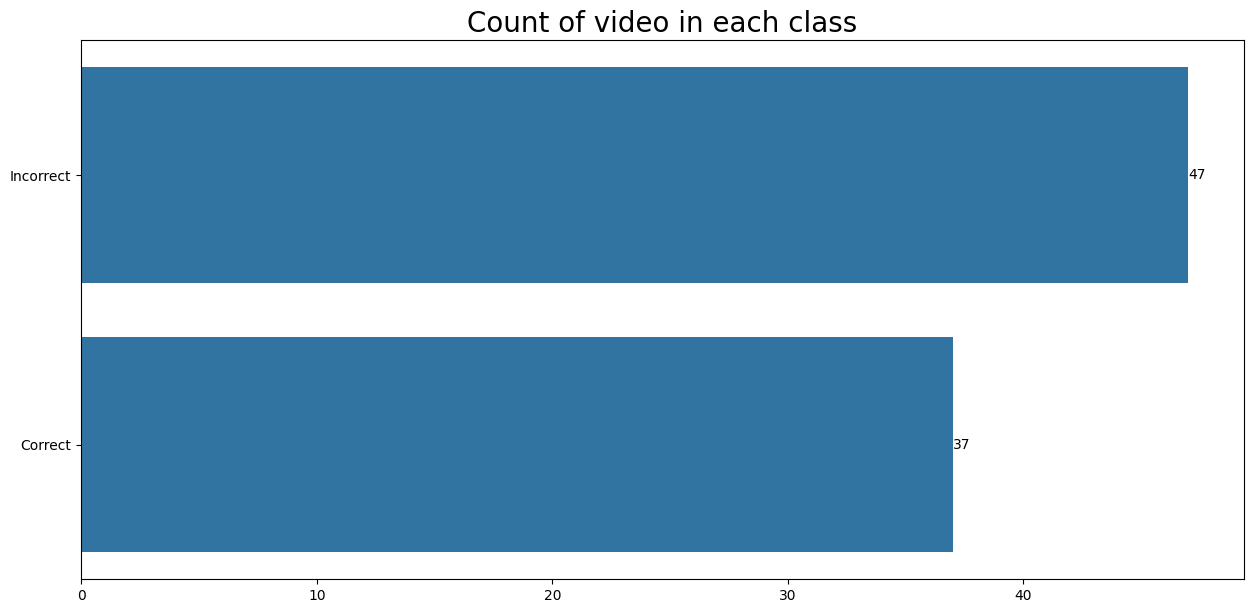

In [ ]:
# --- 5. Split Data ---
tr_df, ts_df = train_test_split(video_df,  train_size= 0.8, shuffle= True, random_state= 20)
valid_df, ts_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 20)

print(f"Train videos: {len(tr_df)}")
print(f"Validation videos: {len(valid_df)}")
print(f"Test videos: {len(ts_df)}")



# Count of images in each class
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of video in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()


Data Generators created.


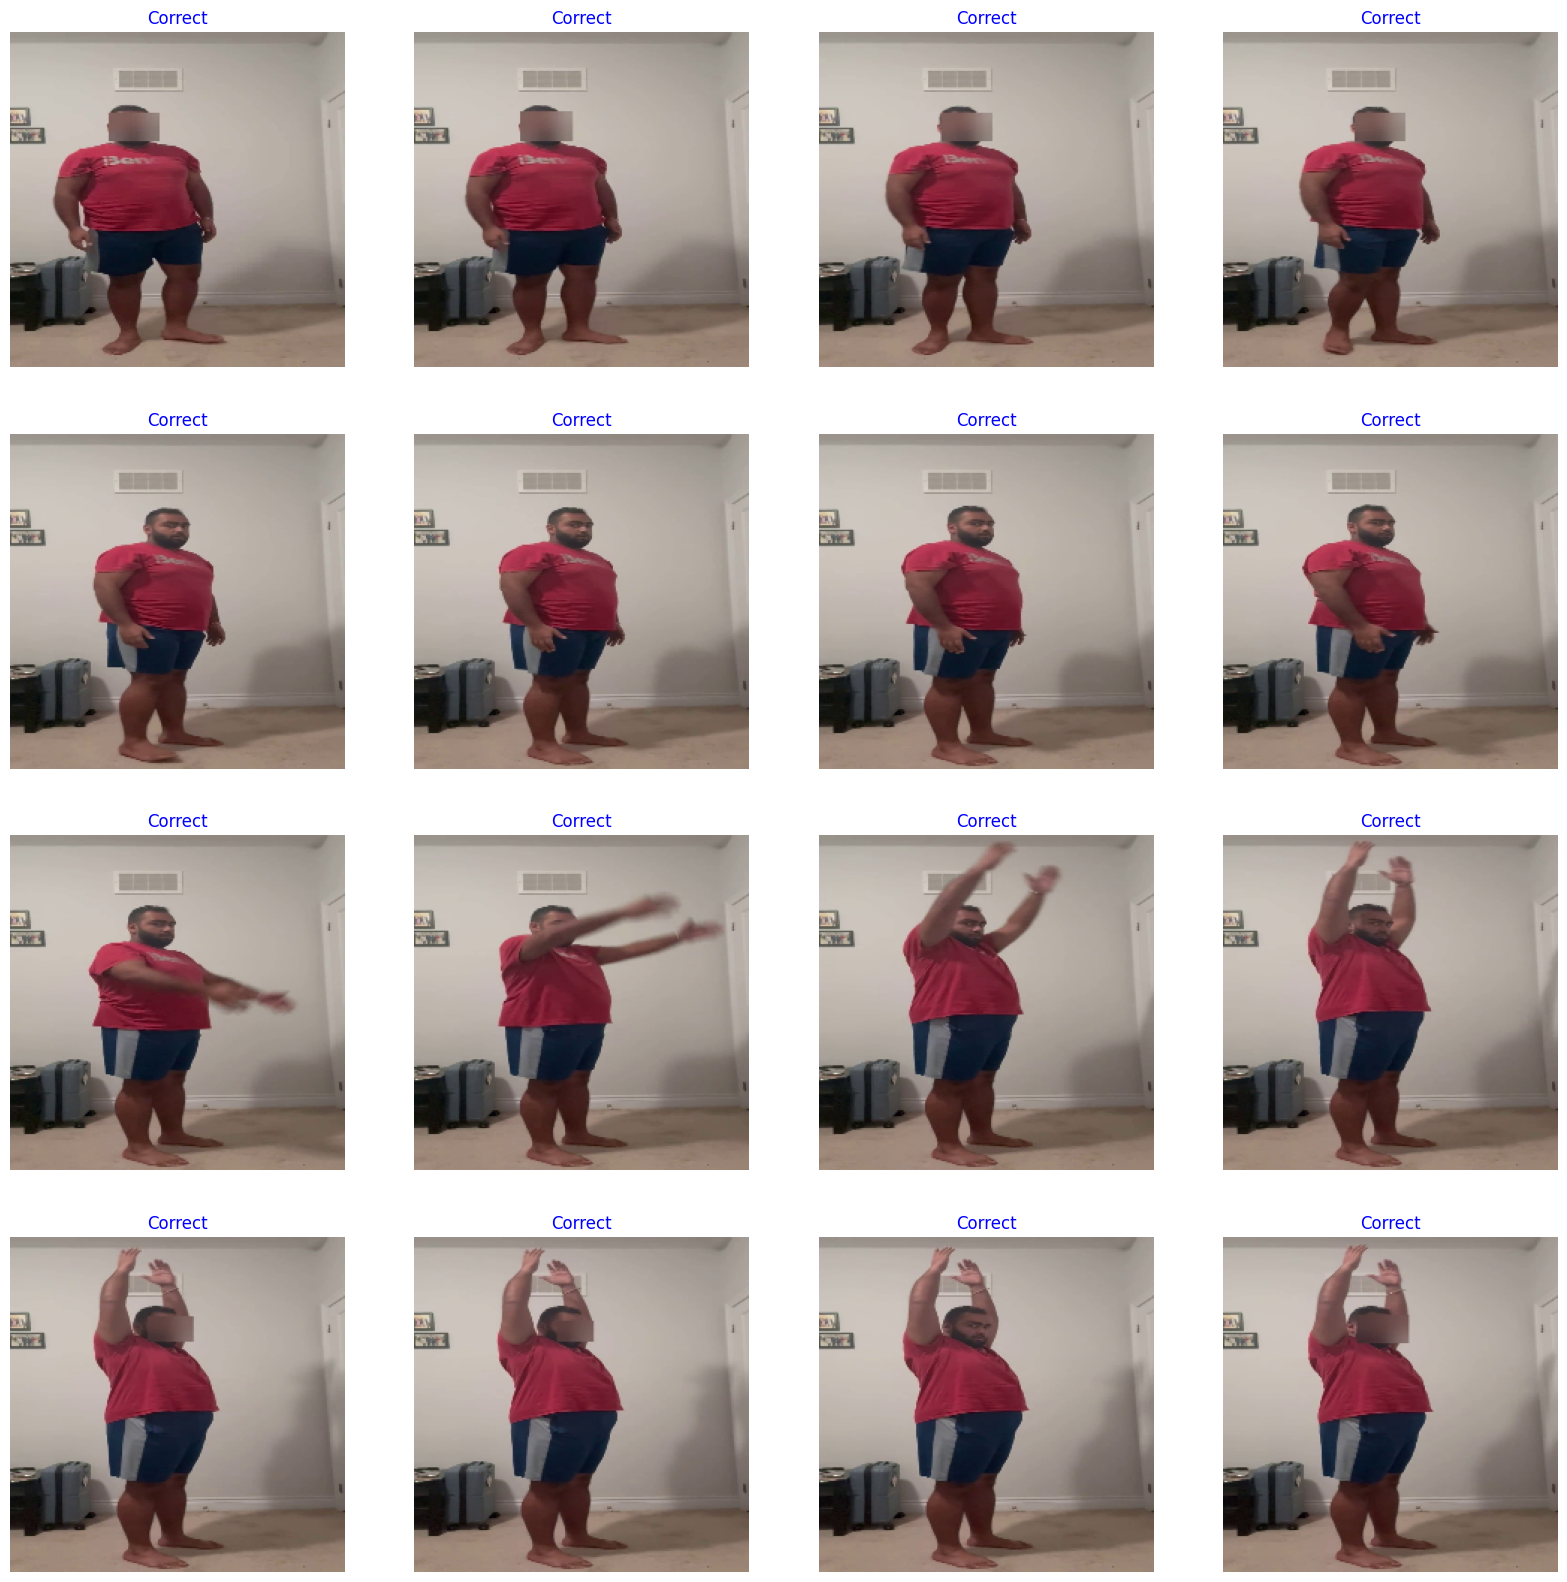

In [ ]:
# --- 6. Create Data Generators ---
# Parameters for frame extraction and batching
num_frames_per_video = 30 # How many frames to sample from each video
image_size = (224, 224) # Size to resize frames to
batch_size_videos = 8 # How many videos to process per batch in the generator
# The actual batch size for model.fit will be batch_size_videos * num_frames_per_video (approximately)

tr_gen = VideoFrameGenerator(tr_df, classes, num_frames=num_frames_per_video,
                              target_size=image_size, batch_size=batch_size_videos,
                              shuffle=True, augment=True)

valid_gen = VideoFrameGenerator(valid_df, classes, num_frames=num_frames_per_video,
                                target_size=image_size, batch_size=batch_size_videos,
                                shuffle=False, augment=False)

ts_gen = VideoFrameGenerator(ts_df, classes, num_frames=num_frames_per_video,
                              target_size=image_size, batch_size=batch_size_videos,
                              shuffle=False, augment=False)

print("\nData Generators created.")


g_dict = tr_gen.class_indices
classes = list(g_dict.keys())
images, labels = ts_gen[0]

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:

# --- 7. Build Deep Learning Model (Image Classification Model) ---
# Using the same EfficientNetB3 model structure as your image code
img_shape = (image_size[0], image_size[1], 3)
num_classes = len(classes)

base_model = EfficientNetB1(include_top=False, weights="imagenet",
                      input_shape= img_shape, pooling= 'max') # pooling='max' aggregates features per frame

model = Sequential([
    base_model,
    # Since base_model has pooling='max', it outputs a vector per frame.
    # If the generator is providing (num_frames_in_batch, H, W, C),
    # the model needs to process each frame.
    # However, the current generator yields (total_frames_in_batch, H, W, C).
    # The model will see each frame as an independent image sample.
    Dense(512,activation= 'relu'),
    Dropout(rate= 0.50, seed= 20),
    Dense(num_classes, activation= 'softmax')
])

# Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = True

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

print("\nModel built:")
model.summary()



Model built:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)     │ (None, 1280)           │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,232,137 (27.59 MB)

 Trainable params: 7,170,082 (27.35 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [ ]:


# --- 8. Train the Model ---
logdir='logs_video'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# **สร้าง EarlyStopping callback**
early_stopping = EarlyStopping(monitor='val_loss', # <-- ตรวจสอบ Validation Loss
                               patience=10, # <-- อดทนรอ 10 epoch ถ้า val_loss ไม่ดีขึ้น
                               restore_best_weights=True) # <-- ใช้ weight ที่ดีที่สุดเมื่อหยุด


print("\nStarting training...")
# Note: The number of steps per epoch is determined by the number of batches
# in the generator (__len__).
hist = model.fit(tr_gen,
                  epochs=5, # Adjust number of epochs
                  validation_data=valid_gen,
                  shuffle= False, # Data is shuffled by the generator
                  callbacks=[tensorboard_callback ,early_stopping])

print("\nTraining finished.")




Starting training...
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 242s 14s/step - accuracy: 0.5036 - loss: 6.3278 - precision_1: 0.5036 - recall_1: 0.5036 - val_accuracy: 0.5000 - val_loss: 1.7715 - val_precision_1: 0.5000 - val_recall_1: 0.5000
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 141s 14s/step - accuracy: 0.3744 - loss: 3.3947 - precision_1: 0.3744 - recall_1: 0.3744 - val_accuracy: 0.5000 - val_loss: 0.7558 - val_precision_1: 0.5000 - val_recall_1: 0.5000
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 134s 13s/step - accuracy: 0.5301 - loss: 0.9888 - precision_1: 0.5301 - recall_1: 0.5301 - val_accuracy: 0.5000 - val_loss: 0.7739 - val_precision_1: 0.5000 - val_recall_1: 0.5000
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 132s 13s/step - accuracy: 0.6329 - loss: 0.6594 - precision_1: 0.6329 - recall_1: 0.6329 - val_accuracy: 0.5000 - val_loss: 0.7210 - val_precision_1: 0.5000 - val_recall_1: 0.5000
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 141s 13s/step - accuracy: 0.6907 - loss: 0.5764 - precision_1: 0.6907 - r


Plotting performance...
History keys: dict_keys(['accuracy', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_loss', 'val_precision_1', 'val_recall_1'])


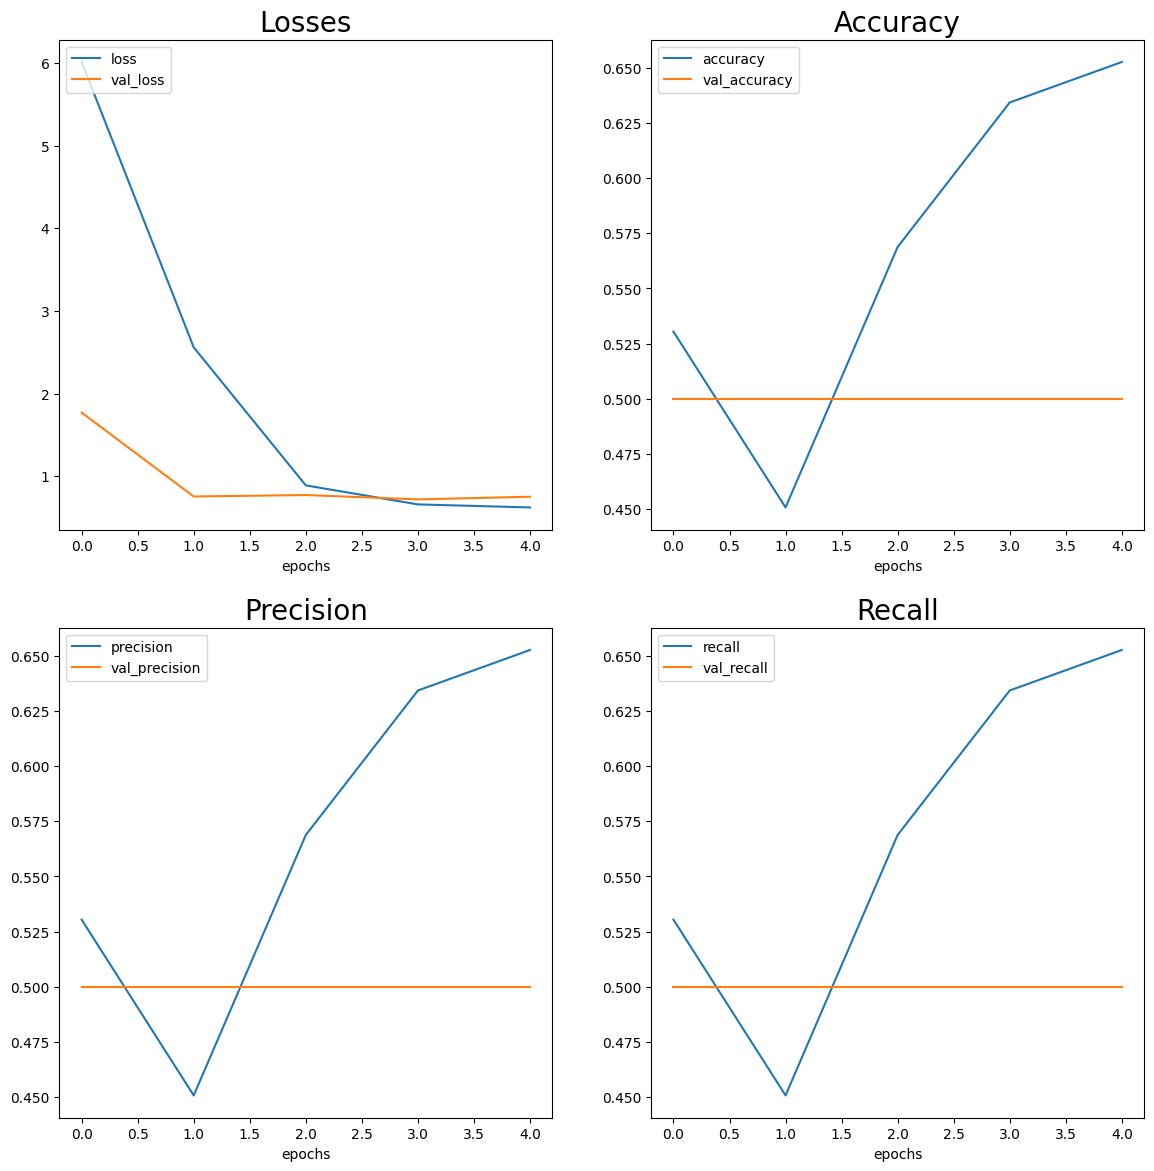

In [ ]:
# --- 9. Plot Performance ---
print("\nPlotting performance...")
# Print the keys in the history dictionary to find the correct metric names
print("History keys:", hist.history.keys())

plt.figure(figsize= (14, 14))

plt.subplot(2,2,1)
plt.plot(hist.history['loss'], label='loss')
if 'val_loss' in hist.history:
      plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], label='accuracy')
if 'val_accuracy' in hist.history:
      plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

# Precision and Recall metric names might vary depending on TensorFlow version
# Check the keys printed above and replace if necessary (e.g., 'precision_1', 'recall')
precision_key = [key for key in hist.history.keys() if 'precision' in key and 'val' not in key][0]
recall_key = [key for key in hist.history.keys() if 'recall' in key and 'val' not in key][0]
val_precision_key = [key for key in hist.history.keys() if 'val_precision' in key][0]
val_recall_key = [key for key in hist.history.keys() if 'val_recall' in key][0]


plt.subplot(2,2,3)
plt.plot(hist.history[precision_key], label='precision')
if val_precision_key:
      plt.plot(hist.history[val_precision_key], label='val_precision')
plt.title('Precision', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.subplot(2,2,4)
plt.plot(hist.history[recall_key], label='recall')
if val_recall_key:
      plt.plot(hist.history[val_recall_key], label='val_recall')
plt.title('Recall', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.show()


In [ ]:

# --- 10. Evaluate the Model ---
print("\nEvaluating the model...")

# Evaluation on generators will evaluate on all frames seen by the generator
# This does not represent video-level performance directly.
# To get video-level performance, you need to predict frame-by-frame
# for each video in the test set and aggregate the predictions per video.

print("\n--- Frame-level Evaluation (Treating each frame independently) ---")
train_score = model.evaluate(tr_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(ts_gen, verbose= 1)

print("Train Loss (Frame-level): ", train_score[0])
print("Train Accuracy (Frame-level): ", train_score[1])
print('-' * 20)
print("Validation Loss (Frame-level): ", valid_score[0])
print("Validation Accuracy (Frame-level): ", valid_score[1])
print('-' * 20)
print("Test Loss (Frame-level): ", test_score[0])
print("Test Accuracy (Frame-level): ", test_score[1])





Evaluating the model...

--- Frame-level Evaluation (Treating each frame independently) ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 113s 11s/step - accuracy: 0.3928 - loss: 0.7899 - precision_1: 0.3928 - recall_1: 0.3928
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5000 - loss: 0.7210 - precision_1: 0.5000 - recall_1: 0.5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.6250 - loss: 0.6555 - precision_1: 0.6250 - recall_1: 0.6250
Train Loss (Frame-level):  0.7641873955726624
Train Accuracy (Frame-level):  0.4375
--------------------
Validation Loss (Frame-level):  0.7210109829902649
Validation Accuracy (Frame-level):  0.5
--------------------
Test Loss (Frame-level):  0.6554927229881287
Test Accuracy (Frame-level):  0.625



--- Video-level Prediction and Reporting ---
Predicting on 11 test videos...

Classification Report (Video-level):
              precision    recall  f1-score   support

     Correct       0.64      1.00      0.78         7
   Incorrect       0.00      0.00      0.00         4

    accuracy                           0.64        11
   macro avg       0.32      0.50      0.39        11
weighted avg       0.40      0.64      0.49        11


Confusion Matrix (Video-level):


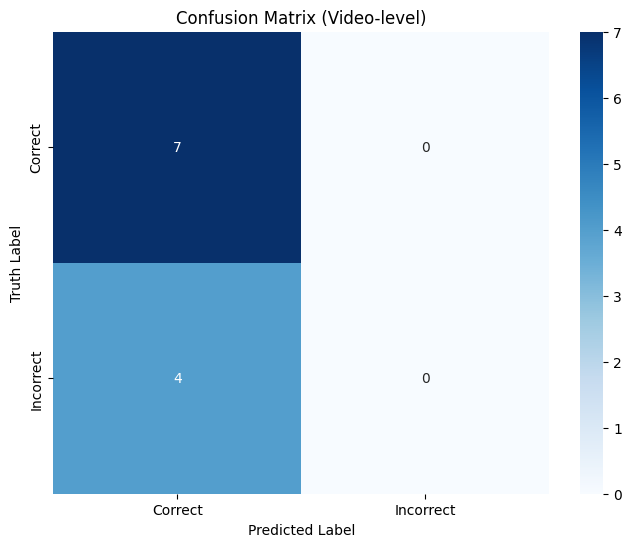

In [ ]:
# --- 11. Prediction and Reporting (Video-level) ---
print("\n--- Video-level Prediction and Reporting ---")

# To get video-level predictions, we need to iterate through the test videos,
# extract frames, predict for each frame, and aggregate the predictions.

video_preds = {}
video_true_labels = {}

print(f"Predicting on {len(ts_df)} test videos...")
for index, row in ts_df.iterrows():
    video_path = row['video_path']
    true_class_name = row['class']
    true_label_index = classes.index(true_class_name)

    frames = extract_frames(video_path, num_frames=num_frames_per_video, target_size=image_size)

    if len(frames) > 0:
        # Predict for each frame
        frame_predictions = model.predict(frames / 255.0, verbose=0) # Normalize frames
        # Aggregate predictions (e.g., average probabilities or majority vote)
        # Averaging probabilities:
        avg_prediction = np.mean(frame_predictions, axis=0)
        predicted_label_index = np.argmax(avg_prediction)

        # Majority vote (alternative):
        # frame_predicted_indices = np.argmax(frame_predictions, axis=1)
        # predicted_label_index = np.bincount(frame_predicted_indices).argmax()


        video_preds[video_path] = predicted_label_index
        video_true_labels[video_path] = true_label_index
    else:
        print(f"Skipping prediction for {video_path} due to no frames.")

# Convert dictionaries to lists for classification_report and confusion_matrix
y_true_video = list(video_true_labels.values())
y_pred_video = list(video_preds.values())

if len(y_true_video) > 0:
      print("\nClassification Report (Video-level):")
      print(classification_report(y_true_video, y_pred_video, target_names= classes))

      # Confusion Matrix (Video-level)
      print("\nConfusion Matrix (Video-level):")
      cm_video = confusion_matrix(y_true_video, y_pred_video)
      plt.figure(figsize=(8,6))
      sns.heatmap(cm_video, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
      plt.xlabel('Predicted Label')
      plt.ylabel('Truth Label')
      plt.title('Confusion Matrix (Video-level)')
      plt.show()

else:
      print("\nNo videos processed for video-level evaluation.")